# **Machine Learning Group Project: Team 7**
## Project overview

| Student Name | Student Number | Class Group |
| --- | --- | --- |
| **Alessandro Maugeri** | 53067 | TA |
| **Frank Andreas Bauer** | 53121 | TA |
|  **Johannes Rahn** | 53958 | TB |
| **Nicole Zoppi** | 53854 | TB |
| **Yannick von der Heyden** | 53629 | TA |



- **Course & Course Code:** Machine Learning (2487)
- **Instructors:** Qiwei Han & Alessandro Gambetti
- **Academic Year:** 2022/2023


### Introduction 

This project was developed by Alessandro Alfio Maugeri, Frank Andreas Bauer, Johannes Rahn, Nicole Zoppi, and Yannick von der Heyden as part of Nova SBE's Machine Learning (2487) course taught during Semester 2 of the 2022/2023 academic year by Professor Qiwei Han and Teaching Assistant Alessandro Gambetti.

### Structure

This project involves using data from two Kaggle pages to create a machine learning pipeline with a clear business use. The data is about Steam's library and includes information on games, DLCs, user reviews, and consensus (e.g. whether a review is positive or not, what general consensus is, how many people found the review useful, etc.).

The project exploits data from two distinct Kaggle pages:

- **Game Recommendations on Steam**
https://www.kaggle.com/datasets/antonkozyriev/game-recommendations-on-steam?select=games.csv
- **Steam Store Games (Clean dataset)**
https://www.kaggle.com/datasets/nikdavis/steam-store-games?select=steam.csv

The primary dataframes final_df, textual_df and the created networks can be directly integrated into the main notebook group7.ipynb. For details on their construction, refer to the appendix_notebooks folder. The final_df is created by merging four CSV files and one JSON file, found in the appendix/raw_data folder. By examining the appendices and raw data, users can understand how these dataframes were built and contribute to the project.

### Business Case 

The objective of this project is to develop an end-to-end Machine Learning pipeline that can predict whether a given Steam user will enjoy a game, based on the similarity of the game's content to his existing library, the user's hours spent in other games and the reviews he wrote. By identifying the best-suited model, the aim is to help Steam optimize its service by tailoring it to individual users and creating a personalized recommender system.

The potential benefits of this recommendation system include providing game suggestions that better match the user's preferences, thereby increasing user engagement and satisfaction with the platform. Additionally, with the help of dynamic pricing, Steam can optimize their revenue by offering games at different prices based on a user's potential enjoyment of a game and, therefore, deduce their willingness to pay.

To ensure a appropriate discount mechanism, the system will utilize a rule-based approach that offers discounts on the most recommended games for each user. These most recommended games will be displayed to the user, with full price being applied to games that the user is very likely to buy based on the ML model predictions. On the other hand, higher discounts will be applied to games that are less recommended.

This approach enables Steam to not only enhance the user experience through personalized recommendations but also to strategically maximize revenue through tailored pricing strategies. By displaying only the highest recommended games and adjusting discounts accordingly, the platform can encourage users to explore and purchase games that are best suited to their preferences. Ultimately, this project aims to create a more intuitive and satisfying gaming platform for users while simultaneously boosting Steam's business performance.


## Importing Packages 

In [4]:
import ast
import csv
import datetime
import warnings
import scipy
import pandas as pd
import numpy as np
from datetime import datetime
from kneed import KneeLocator
from category_encoders import TargetEncoder

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# From sklearn
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, KBinsDiscretizer, OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler

# From imblearn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

# From scipy
from scipy.stats import chi2_contingency, pointbiserialr

## Reading DataFrame

In [5]:
# Optimizing datatypes for efficient DF storage
data_types = {
    'review_id': 'int32',
    'y': 'bool',
    'funny': 'int16',
    'helpful': 'int16',
    'app_id': 'int32',
    'title': 'string',
    'rating': 'category',
    'positive_ratio': 'int16',
    'user_reviews': 'int32',
    'win': 'bool',
    'mac': 'bool',
    'linux': 'bool',
    'price_final': 'float32',
    'price_original': 'float32',
    'discount': 'float32',
    'description': 'string',
    'tags': 'string',
    'english': 'int8',
    'developer': 'category',
    'publisher': 'category',
    'required_age': 'int8',
    'genres': 'string',
    'steamspy_tags': 'string',
    'achievements': 'int16',
    'average_playtime': 'int32',
    'median_playtime': 'int32',
    'owners': 'category',
    'steam_deck': 'bool',
    'user_id': 'int32',
    'products': 'int16',
    'reviews': 'int16',
    'hours': 'float32',
    'categories': 'string'
}

In [6]:
# Import the final DataFrame
final_df = pd.read_csv("data/final_df.csv",
                       dtype=data_types, parse_dates=['date', 'date_release'])

# Import the Textual Data
textual_df = pd.read_csv("data/textual_data.csv", index_col = "app_id")

In [7]:
# Rearrange Columns
final_df = final_df.reindex(columns = ["review_id", "y", "date", "funny", "helpful",
                                       "app_id", "title", "date_release", "rating", 
                                       "positive_ratio", "user_reviews", "win", "mac", "linux", 
                                       "price_final", "price_original", "discount", "description",
                                       "tags", 'english', 'developer', 'publisher', 'required_age', 
                                       'genres', 'steamspy_tags','achievements', 'average_playtime', 
                                       'median_playtime', "owners", "steam_deck",
                                       "user_id", "products", "reviews", "hours"])

# Sort by Review ID
final_df.sort_values(by=["review_id"], inplace = True)

In [8]:
final_df.shape

(6564923, 34)

## Stratified Resampling

The code below performs stratified sampling on the dataset. We do not have the computing power to run all our models on the complete set. Consequently, we provide the possibility of sampling the data down to 100,000 (minimum sample), 500,000 (medium sample), or 1,000,000 (medium-high) sample. The data is stratified according to the target variable so as to prevent the further loss of negative feedback, which is already a strong minority in the set, as will be shown later in the notebook.

Alternatively, by skipping the lines of code below one can use the complete dataset with 6,564,923 observations. This naturally requires the appropriate computing power. 

**Due to our limited computing power, we will be running the entire notebook on 100,000 observations**.

In [9]:
n_total_samples = 100000
#n_total_samples = 500000
#n_total_samples = 1000000

In [10]:
# Find Negative-Positive Ratio
neg_pos_ratio = final_df['y'].value_counts()[0] / final_df['y'].value_counts()[1]

# Determine Number of False and Number of True Samples
n_false_samples = int(n_total_samples * neg_pos_ratio)
n_true_samples = n_total_samples - n_false_samples

# Sample On this Basis 
false_samples = final_df[final_df['y'] == False].sample(n_false_samples, random_state=70)
true_samples = final_df[final_df['y'] == True].sample(n_true_samples, random_state=70)

final_df = pd.concat([false_samples, true_samples])

# shuffle the data
final_df = final_df.sample(frac=1, random_state=70)

We drop all the data inherently describing reviews: being data collected after the user reviewed a game, it doesn't have any predictive value and cannot be used as input for the models.

In [11]:
# Drop unnecessary variables
final_df.drop(['review_id', 'funny', 'helpful'], 
              axis = 1, inplace = True)

## Data Exploration

### General Analysis

Before diving deep into data exploration, let's first take a high-level look at our dataset. We'll examine the number of features and column names.

**Important to note**: In the final_df_prep notebook, we provide detailed definitions of each variable in the dataset. If you find any labels unclear, please refer to that notebook for clarification.

In [12]:
final_df.shape

(100000, 31)

According to our sampling decision, the number of records is now equal to 100,000. The columns are 31.

In [13]:
column_list = final_df.columns.tolist()
print(column_list)

['y', 'date', 'app_id', 'title', 'date_release', 'rating', 'positive_ratio', 'user_reviews', 'win', 'mac', 'linux', 'price_final', 'price_original', 'discount', 'description', 'tags', 'english', 'developer', 'publisher', 'required_age', 'genres', 'steamspy_tags', 'achievements', 'average_playtime', 'median_playtime', 'owners', 'steam_deck', 'user_id', 'products', 'reviews', 'hours']


In [15]:
final_df.dtypes

y                             bool
date                datetime64[ns]
app_id                       int32
title                       string
date_release        datetime64[ns]
rating                    category
positive_ratio               int16
user_reviews                 int32
win                           bool
mac                           bool
linux                         bool
price_final                float32
price_original             float32
discount                   float32
description                 string
tags                        string
english                       int8
developer                 category
publisher                 category
required_age                  int8
genres                      string
steamspy_tags               string
achievements                 int16
average_playtime             int32
median_playtime              int32
owners                    category
steam_deck                    bool
user_id                      int32
products            

Above we notice how the variables have different datatypes and, in particular, how the target "y" is a boolean. This will have to be considered when analysing and handling the variables.

### Target Variable Exploration

First we explore the distribution of our target variable _y_, which is a boolean variable which signals whether a given user would recommend a given game (True) or not (False).

<Figure size 720x360 with 0 Axes>

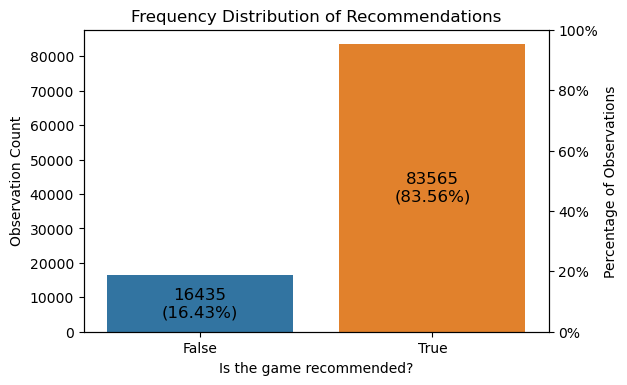

In [16]:
# Plotting the frequency distribution of number of recommendations
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)

ax = sns.countplot(x='y', data=final_df)

plt.title('Frequency Distribution of Recommendations')
plt.xlabel('Is the game recommended?')
plt.ylabel('Observation Count')

# Calculate percentage of each category
percentages = final_df['y'].value_counts(normalize=True) * 100

# Annotate the bars with counts and percentages
for p in ax.patches:
    count = int(p.get_height())
    percentage = percentages.sort_values()[int(p.get_x() + p.get_x())]
    ax.annotate(f'{count}\n({percentage:.2f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2),
                ha='center', va='center', fontsize=12, color='black')

# Add percentage axis
ax2 = ax.twinx()
ax2.set_ylim(0, 100)
ax2.set_ylabel('Percentage of Observations')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

In [17]:
print("The \033[1mratio of positive to negative recommendations\033[0m is", 
     final_df['y'].value_counts()[1] / final_df['y'].value_counts()[0])

The ratio of positive to negative recommendations is 5.08457560085184


In creating a countplot, we find that the dataset is rather unbalanced. Only 16.43% of observations is negative, while the remaining 83.56% is positive. This will certainly be kept in consideration when training our model, as the unbalance must be offset. With a quick calculation, we find that the ratio of positives to negatives is 5.08 approximately.

### Steam Rating Exploration

Remaining within the realm of ratings, we explore the distribution of the Steam rating system through a frequency table. 

In [16]:
# Create a frequency table
rating_counts = pd.DataFrame(final_df['rating'].value_counts())

# Rename the columns
rating_counts.columns = ['Observation Count']

# Sort the rows based on the order of rating categories
rating_order = ["Overwhelmingly Positive", "Very Positive", "Positive", 
                "Mostly Positive", "Mixed", "Mostly Negative", 
                "Negative", "Very Negative", "Overwhelmingly Negative"]

rating_counts = rating_counts.reindex(rating_order)

# Fill NaN with 0
rating_counts.fillna(0, inplace = True)

# Add a column for percentage of observations
rating_counts['Percentage of Observations'] = rating_counts['Observation Count'] / len(final_df) * 100

# Format the percentage column
rating_counts['Percentage of Observations'] = rating_counts['Percentage of Observations'].map('{:.2f}%'.format)

# Turn to Integer
rating_counts["Observation Count"] = [int(i) for i in rating_counts["Observation Count"]]

display(rating_counts)

,Observation Count,Percentage of Observations
Overwhelmingly Positive,23255,23.25%
Very Positive,62738,62.74%
Positive,0,0.00%
Mostly Positive,11689,11.69%
Mixed,2318,2.32%
Mostly Negative,0,0.00%
Negative,0,0.00%
Very Negative,0,0.00%
Overwhelmingly Negative,0,0.00%


Very interestingly, we observe that many of the rating categories are not in fact present in our data. It would seem that there are no games with overall negative reviews, while most games either have a _Very Positive_ or _Overwhelmingly Positive_ rating (appr. 85.99%). All in all, this is in line with the previous observation concerning the unbalanced dataset. 

Another noteworthy aspect of the dataset is that there are no _Positive_ reviews. The remaining 13.76% is split between _Mostly Positive_ and _Mixed_, with the former counting more observation than the latter. It is worth remembering that the Steam rating system assigns the _Positive_ rating to games that seem to have good ratings, but a review count which is not high enough to really "consacrate" its status as a very positively (or overwhlemingly positively) rated game. This perhaps informs us on the type of game which tends to be included in these datasets, focusing on larger more "mainstream" products rather than smaller lesser-known ones.

### Owners Exploration

We plot the frequency distribution of number of owners per game. The ownership data is currently subdivided in categorical strings which simply describe the range of users which any given game has. For the purposes of our model, we will later on tranform the variable through ordinal encoding, merging some of the bins together. This may simplify our model and has the added benefit of ironing out categories which may contain a number of observations far too small compared to other categories. 

<Figure size 720x360 with 0 Axes>

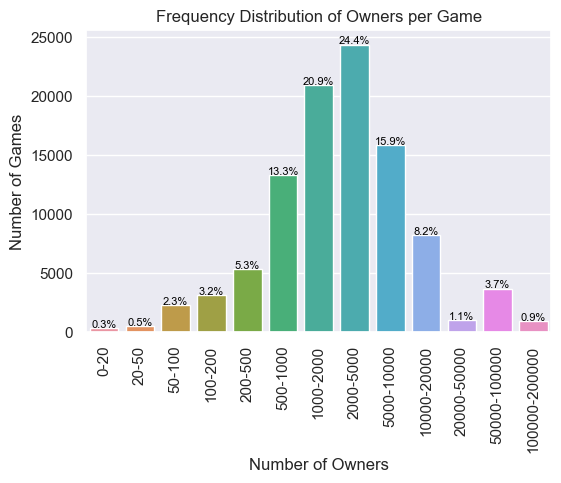

In [18]:
# Create Order
order_list = ["0-20", "20-50", "50-100", "100-200", "200-500",
              "500-1000", "1000-2000", "2000-5000", "5000-10000",
              "10000-20000", "20000-50000", "50000-100000", 
              "100000-200000"]

# Plotting the frequency distribution of owners
sns.set_theme()
plt.figure(figsize=(10, 5))
plt.figure(dpi=100)
plt.xticks(rotation=90)

ax = sns.countplot(x='owners', data=final_df,
                  order = order_list)

# Add percentages to plot
total = len(final_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_y() + p.get_height() + 30
    ax.annotate(percentage, (x, y), ha='center', fontsize=8, color='black')

plt.title("Frequency Distribution of Owners per Game")
plt.xlabel('Number of Owners')
plt.ylabel('Number of Games')
plt.show()

From the results, we can observe the following insights:

The distribution of game ownership is very similar to a normal distribution and the largest group of games (in terms of frequency) are those owned by 2,000 to 5,000 users each. This indicates that a significant portion of games in the dataset falls within this ownership range. Very few games have an extremely high number of owners (100,000-200,000). This implies that only a small number of games become exceptionally popular and reach a large user base. There are also a considerable number of games with a small number of owners (0-20, 20-50, and 50-100). These games might be niche titles, experimental projects, or new releases that have not yet gained popularity. These results suggest that the majority of games in the dataset have a modest user base, with only a few games achieving widespread popularity.

### Discount Rates

Given that discounts are part of the sales process, we attempt to establish whether the _discount_ column contains a satisfactory range of values which may allow us to appropriately enhance the model (or perhaps construct some form of additional model to predict offered discount). 

In [16]:
print("Number of Unique Values in discount column:", len(final_df["discount"].value_counts()))

Number of Unique Values in discount column: 11


In [24]:
discount_count = final_df["discount"].value_counts()
discount_perc = final_df["discount"].value_counts(normalize=True) * 100
discount_df = pd.DataFrame({'Discount Count': discount_count, 'Percentage': discount_perc})
discount_df.index = [f'{round(i, 2)}%' for i in discount_df.index]
discount_df.sort_index(ascending=True, inplace=True)
discount_df

,Discount Count,Percentage
0.0%,94171,94.171
50.0%,435,0.435
60.0%,1100,1.100
65.0%,208,0.208
66.0%,304,0.304
67.0%,112,0.112
75.0%,1618,1.618
80.0%,538,0.538
84.0%,107,0.107
85.0%,134,0.134


The results here are rather disappointing due to the limited range of unique values which this column takes (11), which almost makes it more of a discrete variable than continuous one. Furthermore, only discounts above 50% were retained in this dataset and they are a very large minority compared to games which were purchased at full price.

It would seem that the rich range of possible discounts which were found to exist in [a_csv_creation.ipynb](a_csv_creation.ipynb) were lost in the merging process, particularly when merging the recommendations dataset. This is problematic given that the dataframe is the only truly indispensible one for our model, therefore we cannot run any join that would force games into the dataframe which it does not contain any data for. In that case, we would be foregoing the game-user pairing which is intrinsicially necessary to building our analysis. We do not believe building a model based on the games.csv alone would be useful, as discounts on these platforms are not solely based on game characteristics, but also whether a user is deemed to a good fit for a certain special offer. 

Given these considerations, we will later build a rule-based discount determiner as opposed to a fully automated machine-learning algorithm.

### **Final Prices**

This boxplot provides us with a visual summary of the distribution of the final prices in the dataset. It shows the median, lower quartile, upper quartile, and any potential outliers in the data. This helps us to understand the range and spread of the final prices, which can provide insights into pricing strategies or market conditions. Through the boxplot, we can also identify potential outliers in the data. Those outliers may indicate errors, unusual pricing patterns, or unique market conditions. Identifying these outliers can help us better understand the data and decide how to handle them in further analysis.

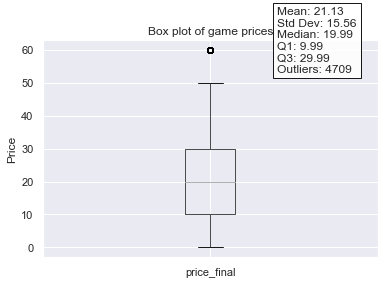

In [25]:
# boxplot of final price
ax = final_df.boxplot('price_final')

ax.set_ylabel('Price')
ax.set_title('Box plot of game prices')

stats = final_df['price_final'].describe()
mean = final_df['price_final'].mean()
std_dev = final_df['price_final'].std()

# calculate outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

outliers = final_df[(final_df['price_final'] < lower_bound) | (final_df['price_final'] > upper_bound)]['price_final']
num_outliers = outliers.count()

# add statistics to the plot
ax.text(0.7, 0.85, f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMedian: {stats['50%']:.2f}\nQ1: {stats['25%']:.2f}\nQ3: {stats['75%']:.2f}\nOutliers: {num_outliers}",
        transform=ax.transAxes, bbox=dict(facecolor='white', edgecolor='black', alpha=0.9))


plt.show()

The mean (average) of the data is 20.82, which means that the typical value in the dataset is around 21.32. The median (middle value) is 19.99, which suggests that half of the data points are below 19.99 and half are above it. Since the mean and median are close to each other, this implies that the data distribution might be roughly symmetrical.

The standard deviation (Std. Dev.) of 16.95 indicates that the data points are spread out over a range of approximately 16.95 units from the mean. A larger standard deviation suggests greater variability in the dataset.

The first quartile (Q1) is 7.99, which means that 25% of the data points are below 7.99. The third quartile (Q3) is 29.99, indicating that 75% of the data points are below 29.99.

There are no outliers in this dataset, which means that all data points fall within a reasonable range and there are no extreme values that could potentially skew the interpretation.

### Game developers and publishers

In this section we explore the top 10 developers and publishers (number of games published and rating). It is important to note that developers can match or be different from publishers.

#### Top 10 ranking of number of unique games released by developers and publisher

In [19]:
# Count the number of unique games released by each developer
developer_counts = final_df.groupby('developer')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_developers = developer_counts.sort_values(ascending=False).head(10)

# Count the number of unique games released by each developer
publisher_counts = final_df.groupby('publisher')['title'].nunique()

# Sort the developers by the number of unique games in descending order and get the top 10
top_10_publishers = publisher_counts.sort_values(ascending=False).head(10)

# Combine top 10 developers and top 10 publishers DataFrames
top_10_developers_df = top_10_developers.to_frame().reset_index().rename(columns={'title': 'unique_games'})
top_10_publishers_df = top_10_publishers.to_frame().reset_index().rename(columns={'title': 'unique_games'})
combined_df = pd.concat([top_10_developers_df, top_10_publishers_df], axis=1, keys=['Developers', 'Publishers'])

# Print the top 10 developers and top 10 publishers side by side
combined_df

Developers                                 Publishers  \
                    developer unique_games                     publisher   
0                       Valve            6                       Ubisoft   
1       Bethesda Game Studios            6            Bethesda Softworks   
2  KOEI TECMO GAMES CO., LTD.            4           Paradox Interactive   
3    Spike Chunsoft Co., Ltd.            4                          SEGA   
4            CAPCOM Co., Ltd.            4                         Valve   
5  Paradox Development Studio            4      Spike Chunsoft Co., Ltd.   
6                 Square Enix            3    BANDAI NAMCO Entertainment   
7      Obsidian Entertainment            3                    Activision   
8                    Treyarch            3                   Square Enix   
9                      Capcom            3  2K;Aspyr (Mac);Aspyr (Linux)   

                
  unique_games  
0           10  
1           10  
2            8  
3            8  
4            8  
5            8  
6            6  
7            5  
8            5  
9            4

In [20]:
unique_games = final_df['title'].nunique()
print(f"Number of unique games: {unique_games}")

Number of unique games: 299


In [21]:
unique_developers = final_df['developer'].nunique()
print(f"Number of unique developers: {unique_developers}")


Number of unique developers: 251


In [22]:
unique_publishers = final_df['publisher'].nunique()
print(f"Number of unique publishers: {unique_publishers}")


Number of unique publishers: 197


From the data, we can see that Valve and Ubisoft are the most prolific developers and publishers respectively, having developed and published 6 and 10 unique games each. Bethesda Game Studios and Bethesda Softworks follow closely with 6 unique games each.

Overall, we can state that both the publishers and the developers are not highly concentrated: we can't identify major players, but small - and probably - independent ones.

#### Top 10 ranking of developers with best positive rating

In [23]:
# Calculate the average positive rating for each developer
average_positive_ratings = final_df.groupby('developer')['positive_ratio'].mean()

# Sort the developers by the average positive rating in descending order and get the top 10
top_10_developers_positive_ratings = average_positive_ratings.sort_values(ascending=False).head(10)

# Print the top 10 developers with the best average positive ratings
top_10_developers_positive_ratings


developer
Kristjan Skutta          98.0
Ludeon Studios           98.0
ConcernedApe             98.0
Bevan McKechnie          97.0
Matt Makes Games Inc.    97.0
Monomi Park              97.0
Lucas Pope               97.0
Nicalis, Inc.            97.0
Ninja Kiwi               97.0
Re-Logic                 97.0
Name: positive_ratio, dtype: float64

The results of the top 10 developers with the most unique games don't match the list of the top 10 developers based on best positive ratings. Therefore, we can conclude that a developer who has developed more games does not necesarrely develop better rated games.

### **Relationship between Products Owned and Number of Reviews**

Looking at the relationship between products owned and the number of reviews can give insight into user engagement with a product.

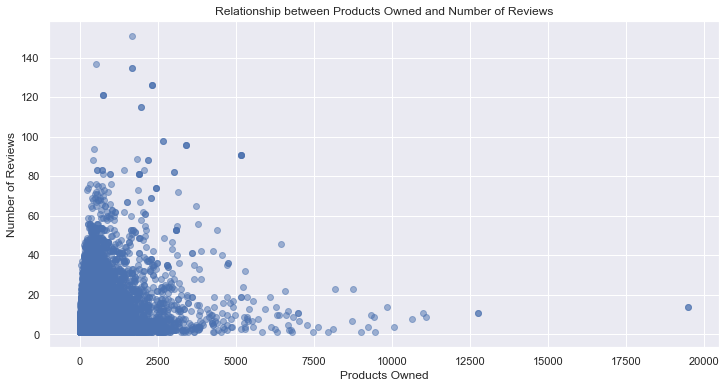

Correlation coefficient between Products Owned and Number of Reviews: 0.32


In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(final_df['products'], final_df['reviews'], alpha=0.5)
plt.xlabel('Products Owned')
plt.ylabel('Number of Reviews')
plt.title('Relationship between Products Owned and Number of Reviews')
plt.show()

correlation = final_df['products'].corr(final_df['reviews'])
print(f"Correlation coefficient between Products Owned and Number of Reviews: {correlation:.2f}")

The correlation coefficient of 0.32 indicates a weak positive relationship between the number of products owned and the number of reviews written. This means that, in general, as the number of products owned increases, there is a slight tendency for the number of reviews written to increase as well.

Some of the reasons for this weak positive correlation could be:

- **Time constraints**: users who own a large number of games might not have enough time to play all of them extensively, and thus may not feel confident in writing a review for each game.
- **Review motivation**: different users might have varying motivations for writing reviews. Some might only write reviews for games they are passionate about, while others might review games they had a negative experience with. The number of products owned may not directly influence these motivations.
- **Game quality and user preferences**: not all games are equally engaging, and users might only write reviews for games that align with their preferences or that they find exceptionally good or bad.
- **Review-writing habits**: some users might be more inclined to write reviews than others, regardless of the number of games they own. For example, a user who is an active participant in the Steam community might write more reviews than someone who mainly uses the platform to play games.

### **Compatibility of Windows, Mac and Linux**

Analyzing the compatibility between different operating systems helps us to understand the market distribution of each platform. Each operating system has a different market share, and understanding the distribution can inform us about a potential correlation between the platforms where a game is available and its review score. 

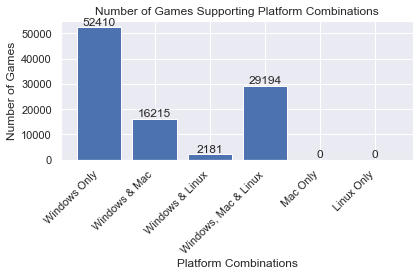

In [26]:
# Calculate the number of games supporting each combination of platforms (windows, mac, linux)

win_only = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == False)).sum()
win_mac = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
win_linux = ((final_df['win'] == True) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()
win_mac_linux = ((final_df['win'] == True) & (final_df['mac'] == True) & (final_df['linux'] == True)).sum()
mac_only = ((final_df['win'] == False) & (final_df['mac'] == True) & (final_df['linux'] == False)).sum()
linux_only = ((final_df['win'] == False) & (final_df['mac'] == False) & (final_df['linux'] == True)).sum()

# Platform combinations and their counts

platform_combinations = {
    "Windows Only": win_only,
    "Windows & Mac": win_mac,
    "Windows & Linux": win_linux,
    "Windows, Mac & Linux": win_mac_linux,
    "Mac Only": mac_only,
    "Linux Only": linux_only,
}

fig, ax = plt.subplots()
ax.bar(platform_combinations.keys(), platform_combinations.values())

# Add the counts above the bars
for i, (combination, count) in enumerate(platform_combinations.items()):
    ax.text(i, count + 10, f"{count}", ha='center', va='bottom')

ax.set_title("Number of Games Supporting Platform Combinations")
ax.set_xlabel("Platform Combinations")
ax.set_ylabel("Number of Games")

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The plot shows that Windows definitly dominates when it comes to the number of games it supports: indeed, most developers only develop for windows. However, there are still many games which run on 2 or more operating systems: for this reason we will later on create dummy variables for compatibility data in order to further develop interaction variables.

### **Trends in game releases, user reviews, and ratings over time**

Analyzing the follwing trends helps us to identify patterns in the gaming industry, such as seasonal variations in game releases and user reviews. Examining the number of games released, of user reviews and the average rating over time can help us identify whether the release date has an impact in the users' perception of a game.

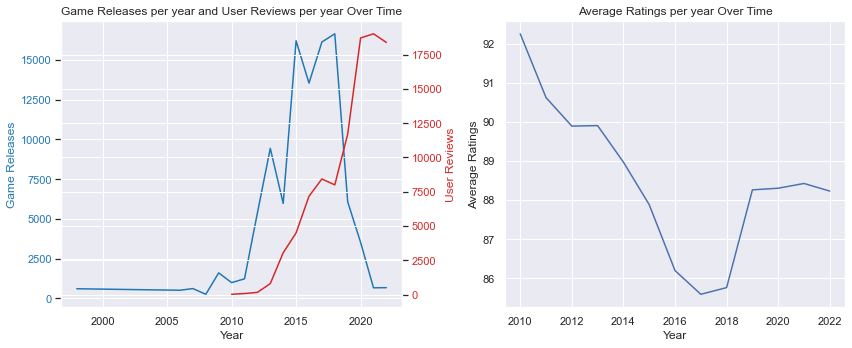

In [26]:
# Trends in game releases, user reviews, and ratings over time

final_df['date_release'] = pd.to_datetime(final_df['date_release'])
final_df['date'] = pd.to_datetime(final_df['date'])

game_releases_by_year = final_df.groupby(final_df['date_release'].dt.year).size()
user_reviews_by_year = final_df.groupby(final_df['date'].dt.year)['user_reviews'].size()

avg_ratings_by_year = final_df.groupby(final_df['date'].dt.year)['positive_ratio'].mean()

fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(12, 5))

# Plot Game Releases and User Reviews Over Time
ax1.set_xlabel('Year')
ax1.set_ylabel('Game Releases', color='tab:blue')
ax1.plot(game_releases_by_year.index, game_releases_by_year, color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('User Reviews', color='tab:red')
ax2.plot(user_reviews_by_year.index, user_reviews_by_year, color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

ax1.set_title('Game Releases per year and User Reviews per year Over Time')

# Plot Average Ratings Over Time
ax3.plot(avg_ratings_by_year.index, avg_ratings_by_year)
ax3.set_xlabel('Year')
ax3.set_ylabel('Average Ratings')
ax3.set_title('Average Ratings per year Over Time')

fig.tight_layout()
plt.show()

From our plot, we can observe the following trends:

- **Game releases**: The number of game releases increased from 2006 to 2018, indicating a growing interest in gaming and game development over this period. However, there was a significant drop in game releases after 2018. This drop could be due to various reasons, such as market saturation, a shift in focus towards higher-quality games with longer development cycles, or the rise of alternative gaming platforms like mobile and VR.
- **User reviews**: The number of user reviews saw a strong increase since their introduction in 2013, peaking in 2022. This could be attributed to the growing gaming community and the increasing importance of user feedback in the gaming industry. As more people got into gaming and online platforms became more accessible, users became more likely to share their opinions and experiences. This trend suggests that user reviews have become a critical factor for gamers when deciding to purchase or play a game.
- **Average ratings**: The average rating decreased from 2010 to 2018, possibly because of the increasing number of game releases, which might have led to a higher proportion of lower-quality games. This decrease could also be attributed to gamers becoming more critical and discerning over time. However, the average rating started to slightly increase again from 2018 to 2022. This trend might be due to the gaming industry's response to user feedback, leading to improvements in game quality and an increased focus on satisfying gamers' expectations.

### **Comparison of mean playtime and median playtime in terms of skewness**

We compare mean and median playtime in terms of skewness to gain a better understanding of the distribution of the 'hours' column. This helps use to decide whether to use the mean or median for further analysis.

Number of outliers in 'hours' column: 8130
Skewness of 'hours' column: 1.6005194187164307
The 'hours' column is highly skewed. It is recommended to use the median for further analysis.


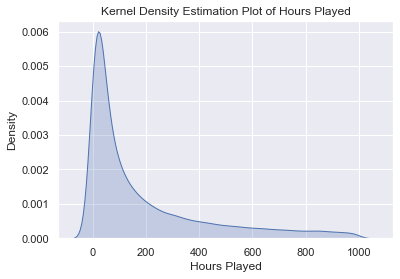

In [27]:
# Step 1: Assess the distribution of the 'hours' column
skewness = final_df['hours'].skew()

# Step 2: Use a for loop to identify outliers (using the IQR method)
Q1 = final_df['hours'].quantile(0.25)
Q3 = final_df['hours'].quantile(0.75)
IQR = Q3 - Q1

outliers = []
for hours in final_df['hours']:
    if (hours < (Q1 - 1.5 * IQR)) or (hours > (Q3 + 1.5 * IQR)):
        outliers.append(hours)

# Print the number of outliers and skewness value
print(f"Number of outliers in 'hours' column: {len(outliers)}")
print(f"Skewness of 'hours' column: {skewness}")

# Step 3: Decide whether to use the median or the mean for further analysis
if skewness > 1 or skewness < -1:
    print("The 'hours' column is highly skewed. It is recommended to use the median for further analysis.")
else:
    print("The 'hours' column is not highly skewed. It is recommended to use the mean for further analysis.")


# Create a kernel density estimation plot for the 'hours' column
sns.kdeplot(final_df['hours'], shade=True)

# Add labels and title
plt.xlabel('Hours Played')
plt.ylabel('Density')
plt.title('Kernel Density Estimation Plot of Hours Played')

# Show the plot
plt.show()

There are 8130 data points in the 'hours' column that are considered outliers, based on the Interquartile Range (IQR) method. These data points lie outside the typical range of values, and they might have a significant impact on the mean and standard deviation.

The 'hours' column is highly skewed. The skewness of the 'hours' column is either greater than 1, indicating that the distribution is not symmetric and has a significant tail on one side. In this case, the tail is likely on the right side, meaning that there are a few games with extremely high playtimes compared to the majority. 

Given these results, it is recommended to use the median instead of the mean for further analysis of the 'hours' column. The median is less sensitive to outliers and provides a more accurate representation of the central tendency of the data. By using the median, you can mitigate the impact of extreme values and better understand the typical playtime for games in the dataset.

## Correlation

Since the variable 'y' is binary, and the dataset is composed of categorical, binary and continuous variable, we calculated the correlations with different coefficients.

### Continuous Variables
To calculate the correlation between "y" and continous variables, we use the point-biserial correlation coefficient. 
The point biserial correlation is the value of Pearson's product moment correlation when one of the variables is dichotomous, taking on only two possible values, and the other variable is metric (interval or ratio). The metric variable should be approximately normally distributed for both groups (_Kornbrot, Diana. "Point biserial correlation." Wiley StatsRef: Statistics Reference Online (2014)_).

We verify that the variables meet the requirements for the point-biserial correlation examinating each of them throught an histogram to check for the distribution.

In [28]:
# Define the numeric variables
num_variables = ['price_final', 'positive_ratio', 'hours', 'median_playtime', 'user_reviews',
                'price_original', 'discount', 'products', 'reviews']

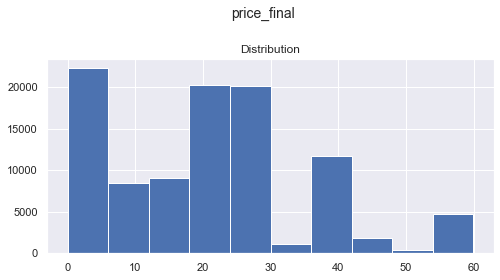

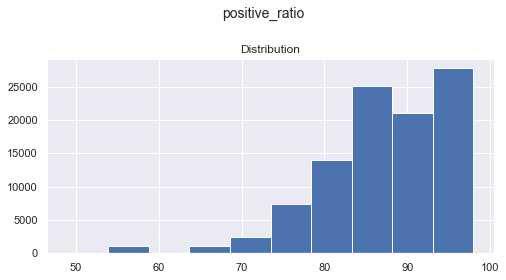

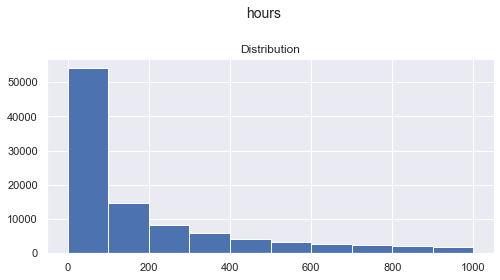

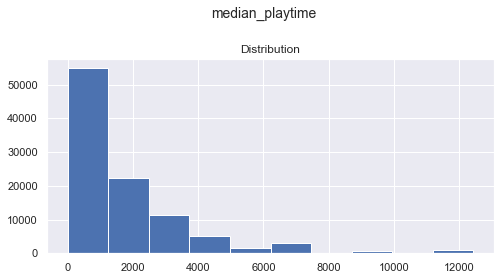

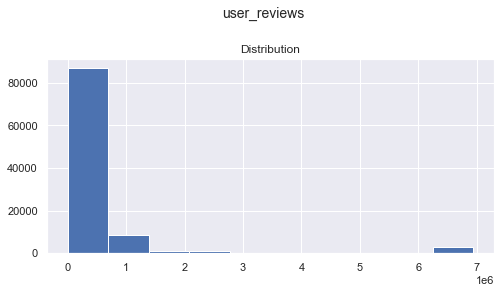

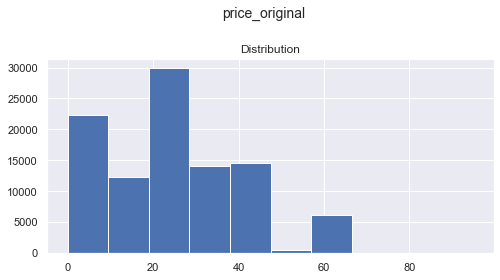

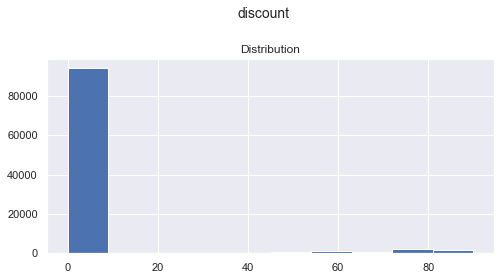

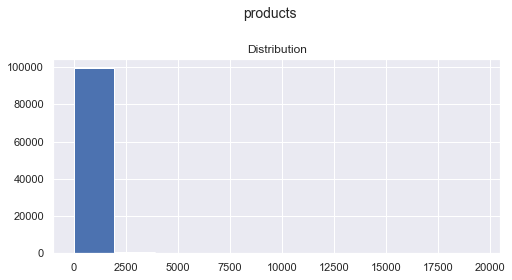

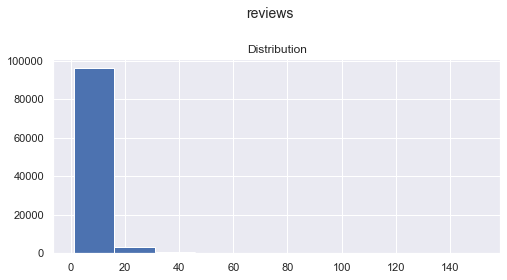

In [30]:
# loop through the numeric variables
def check_req(df, variable_list):
    for var in variable_list:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))

        axs.hist(df[var])
        axs.set_title("Distribution")

        plt.suptitle(var, fontsize=14)
        fig.subplots_adjust(top=0.8)

        plt.show()
        
check_req(final_df, num_variables)

In most cases, the distribution of our continuous variable does not resemble a bell curve or normal distribution, which may impact the reliability of our analysis. 

To address this issue and better meet the assumptions of the models we employ, we have decided to normalize the data. This transformation will help account for the non-normal distribution of the continuous variable, ultimately improving the validity of our findings.

In [31]:
# Create a new DataFrame to store the normalized variables
final_df_log = pd.DataFrame()

var_to_norm = ['hours', 'median_playtime', 'user_reviews',
                'products', 'reviews']

# Loop over the variables and apply log transformation to each one
for col in var_to_norm:
    final_df_log[col] = np.log(final_df[col] + 0.0001)
    
final_df_norm = pd.concat([final_df.drop(var_to_norm, axis=1), final_df_log], axis=1)

In [32]:
# Calculate correlation based on the normalized dataset 
cor_matrix = []

for variable in num_variables:
    r_pb, p_value = pointbiserialr(final_df_norm['y'], final_df_norm[variable])
    cor_matrix.append({'Variable name': variable, 'corr': r_pb, 'p-value': p_value})

cor_df = pd.DataFrame(cor_matrix)
cor_df['corr'] = abs(cor_df['corr'])
display(cor_df.sort_values(by="corr", ascending = False))

,Variable name,corr,p-value
1,positive_ratio,0.264822,0.000000e+00
2,hours,0.172609,0.000000e+00
7,products,0.085274,9.876050e-161
8,reviews,0.061251,9.908749e-84
4,user_reviews,0.034498,1.005455e-27
0,price_final,0.033896,8.039414e-27
5,price_original,0.025275,1.307406e-15
3,median_playtime,0.003413,2.804626e-01
6,discount,0.003025,3.387933e-01


Making the correlation coefficient absolute, we can state the the variables more with a stronger correlation to y are positive_ratio and hours. The ones that follow in the dataset are still correlated (all the p-values are <0.5), but with coefficients lower than 10%.

In any case, we notice that the correlations are not strong across all the variables, with values that don't go over 25%. Plus, we are aware that the normality requirement is slightly flawned.

### Binary variables
Phi is a measure for the strength of an association between two categorical variables in a 2 × 2 contingency table. It is calculated by taking the chi-square value, dividing it by the sample size, and then taking the square root of this value. It varies between 0 and 1 without any negative values.

In [32]:
# Define binary variables
bin_variables = ['mac', 'linux']

In [33]:
# Check that they all have two different values
for var in bin_variables: 
    print(var, final_df[var].unique())

mac [False  True]
linux [False  True]


In [34]:
# Calculate their phi value and its p-value
warnings.filterwarnings("ignore", category=FutureWarning)

phi_df = pd.DataFrame(columns=['Variable name', 'corr', 'p-value'])

for var in bin_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    ChiSqResult = chi2_contingency(contingency)
    n = contingency.values.sum()
    phi = np.sqrt(ChiSqResult[0] / n)
    p_value = ChiSqResult[1]
    
    phi_df = phi_df.append({'Variable name': var, 'corr': phi, 'p-value': p_value}, ignore_index=True)

display(phi_df)

,Variable name,corr,p-value
0,mac,0.083813,0.0
1,linux,0.090717,0.0


Once again, we notice that the correlation values are very low. Plus, the p-value gets rounded to 0: this could be both because it has an extremely low value, or because the calculation of the chi-square value fails to calculate an accurate result.

### Categorical variables
Cramer's V is an alternative to phi in tables bigger than 2 × 2 tabulation. Cramer's V varies between 0 and 1 without any negative values. Similar to Pearson's r, a value close to 0 means no association. However, a value bigger than 0.25 is named as a very strong relationship for the Cramer's V.

In [35]:
# Define categorical variables
cat_variables = ['rating', 'developer', 'publisher', 'achievements']

In [36]:
# Check that they all have more than two different values
for var in cat_variables: 
    print(var, final_df[var].nunique())

rating 4
developer 251
publisher 197
achievements 113


In [37]:
# calculate Cramer V coefficient for each variable and y
results = []
for var in cat_variables:
    contingency = pd.crosstab(final_df['y'], final_df[var])
    chi2 = chi2_contingency(contingency)[0]
    N = len(final_df)
    minimum_dimension = (min(contingency.shape)-1)
    result = np.sqrt((chi2/N) / minimum_dimension)
    p_value = chi2_contingency(contingency)[1]
    results.append({'Variable name': var, 'corr': result, 'p-value': p_value})

# create dataframe with results
results_df = pd.DataFrame(results).sort_values(by='corr', ascending=False)

display(results_df)

,Variable name,corr,p-value
1,developer,0.286049,0.0
2,publisher,0.275078,0.0
0,rating,0.235758,0.0
3,achievements,0.209119,0.0


In this case, the correlation values are slightly higher. However, the problem with the p-value constantly equal to 0 persists.

### Conclusions
Given the low values of correlation coefficients and the small calculation flawns, we will use other techniques to assess whether we should include or not a feature in our models. In particular, we will use L1 regularization to remove completely unrelevant features and to understand which ones have a stronger impact.

## Custom Pipeline Class Construction

To improve the potential performance of our models we decided to generate new features and further work on the existing ones. To do so, we created different pipelines to apply to our dataset.

### Feature Engineering

#### Elapsed Time
Here we construct the custom pipeline class ElapsedTimeTransformer, which creates a new feature called _elapsed_time_. This is the amount of time which has passed since a product's release date and the user reviewing it. This could be a proxy for how "into a product" a given user could be (in the context of elapsed time, a value of 0 signifies that a user left a review on the very same day of its release). The class takes the following arguments:
- **add_elapsed**: Receives a boolean to determine whether to create the new column. Deafult is True
- **drop_features**: Receives a boolean to determine whether to drop _date_ and _date_release_ columns after having created _add_elapsed_. These variables are not particularly useful for the regression so it may be worthwhile to remove them from the DataFrame. Default is True.

In [38]:
class ElapsedTimeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, add_elapsed=True, drop_features=True):
        self.add_elapsed = add_elapsed
        self.drop_features = drop_features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.add_elapsed:
            X = X.copy()
            elapsed_time = (pd.to_datetime(X["date"]) - pd.to_datetime(X["date_release"])).dt.days
            X = X.assign(elapsed_time=elapsed_time)

        if self.drop_features:
            X = X.drop(['date', 'date_release'], axis=1)

        return X

#### Tendency to Review
Here we construct the custom pipeline class TendencyToReview. Its purpose is to create a new feature _tendency_to_review_ which is the ratio between reviews by a user and number of products he/she owns. It allows us to gauge how often a user leaves reviews. People tend to rarely leave reviews, as shown in the exploratory data analysis above. Consequently, the class standardises the resulting data. The arguments are the following:
- **drop_words**: Receives a boolean to determine whether to drop _products_ column. Deafult is True.
- **standardize**: Receives a boolean to determine whether to standarsize the resulting data or not. Default is True.

In [39]:
class TendencyToReview(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_words=True, standardize=True):
        
        self.drop_words = drop_words
        self.standardize = standardize

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X["tendency_to_review"] = (X["reviews"]) / (X["products"])
        X["tendency_to_review"] = np.where(X["tendency_to_review"] == np.inf, 2, X["tendency_to_review"])
        if self.drop_words:
            X = X.drop("products", axis=1)
        if self.standardize:
            scaler = MinMaxScaler()
            X["tendency_to_review"] = scaler.fit_transform(X[["tendency_to_review"]])
        return X

#### Ordinally Encoded Steam Rating
Here we construct the custom pipeline class SteamRatingEncoder. Its purpose is to transform the Steam categorical ratings in the _rating_ column (whose meanings are better explained in final_df_prep.ipynb) into an ordinally encoded feature. However, given that the categories follow a diverging pattern (where "Mixed" is a middle ground and games can have varying degrees of Positive or Negative feedback), we encode them as such. We give users the possibility of encoding them with a standard scale that goes from -4 to 4, or a slightly more weighted one which attempts to numerically translate the large difference between being simply "Mostly Positive" (or Negative) and being "Positive" (or Negative). The class has the following arguments:

- **drop_rating**: Receives a boolean to determine whether to drop the _rating_ categorical column. Deafult is True.
- **standard_diverging_scale**: Receives a boolean to determine whether to use the standard scale instead of the weighted one. Default is True.

In [40]:
class SteamRatingEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_rating=True, standard_diverging_scale=True):
        
        self.drop_rating = drop_rating
        self.standard_diverging_scale = standard_diverging_scale
        
        if standard_diverging_scale:
            self.rating_dict = {
                "Overwhelmingly Positive": 4,
                "Very Positive": 3,
                "Positive": 2,
                "Mostly Positive": 1,
                "Mixed": 0,
                "Mostly Negative": -1,
                "Negative": -2,
                "Very Negative": -3,
                "Overwhelmingly Negative": -4
            }
        else:
            self.rating_dict = {
                "Overwhelmingly Positive": 9,
                "Very Positive": 8,
                "Positive": 7,
                "Mostly Positive": 4,
                "Mixed": 0,
                "Mostly Negative": -4,
                "Negative": -7,
                "Very Negative": -8,
                "Overwhelmingly Negative": -9
            }
            
        self.drop_rating = drop_rating

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['rating_encoded'] = X['rating'].map(self.rating_dict)
        if self.drop_rating:
            X = X.drop(['rating'], axis=1)
        return X

#### Developer and Distributor Metrics
Here we construct the custom pipeline class DevDisTransformer. Depending on the arguments which are passed to it, it can create up to three new features. It utilizes target encoding on both the developer and distributor columns and has gives the users the possibility to also create an interaction feature between these two variables. The idea is that there may be developers which tend to put out better games than others, or distributors which tend to pick up better games than others. Sometimes, it is the collaboration between a particular developer and distributor which creates true "videogaming gold". Consequently, we give the possibility of creating an interaction term. The class' arguments are the following:
- **y**: Receives the y values corresponding to the dataset being transformed. Needed for Target Encoding.
- **encode_dev**: Receives a boolean to determine whether to target encode the _developer_ column. Deafult is True.
- **encode_dis**: Receives a boolean to determine whether to target encode the _distributor_ column. Deafult is True.
- **drop_cols**: Receives a boolean to determine whether to drop the _developer_ and _distributor_ columns after the transformation. Default is True.
- **interaction**: Receives a boolean to determine whether to create interaction term or not. Default is True.

In [41]:
class TargetEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, y, encode_dev=True, encode_dis=True, drop_cols=True, interaction=True):
        self.encode_dev = encode_dev
        self.encode_dis = encode_dis
        self.drop_cols = drop_cols
        self.interaction = interaction
        self.y = y
        self.encoder_dev = TargetEncoder()
        self.encoder_dis = TargetEncoder()

    def fit(self, X, y=None):
        if self.encode_dev:
            self.encoder_dev.fit(X["developer"], self.y)
        if self.encode_dis:
            self.encoder_dis.fit(X["distributor"], self.y)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        if self.encode_dev:
            X["targ_encode_dev"] = self.encoder_dev.transform(X["developer"])
        if self.encode_dis:
            X["targ_encode_dis"] = self.encoder_dis.transform(X["distributor"])
        if self.interaction:
            X["dev_dis_interaction"] = X["targ_encode_dev"] * X["targ_encode_dis"]
        if self.drop_cols:
            X.drop(columns=["developer", "distributor"], inplace=True)
        return X


#### Genre Dummy Interactions
Here we construct the custom pipeline class InteractionsTransformer. When called, it finds the maximum number of genre dummies which are positive across all rows. Based on what it finds, it calls a PolynomialFeatures with the approriate degree to capture every single interaction without making the features overly complex (e.g. by setting a higher degree than necessary to capture all interactions). The PolynomialFeatures only returns the interaction terms (no quadratic terms) and adds them to the DataFrame. This can be used for both the genre dummies and the OS dummies. The argument is only one:

- **columns**: Receives the columns with dummies. If not specified, the list of genres in our dataset is used.

In [42]:
class InteractionsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns=None):
        if columns is None:
            columns = ['Action', 'Adventure', 'Animation & Modeling', 'Casual',
                       'Design & Illustration', 'Early Access', 'Free to Play', 'Gore',
                       'Indie', 'Massively Multiplayer', 'Nudity', 'RPG', 'Racing',
                       'Sexual Content', 'Simulation', 'Sports', 'Strategy',
                       'Utilities', 'Violent', 'Web Publishing']
        self.columns = columns
    
    def fit(self, X, y=None):
        # Extract the relevant columns and find the maximum number of positive dummies
        X_cols = X.loc[:, self.columns]
        max_positives = X_cols.sum(axis=1).max()
        
        # Set the degree of PolynomialFeatures to the maximum number of positive dummies
        self.poly = PolynomialFeatures(interaction_only=True, degree=max_positives)
        
        # Fit the PolynomialFeatures transformer
        self.poly.fit(X_cols)
        
        return self
    
    def transform(self, X):
        # Apply the PolynomialFeatures transformer to the relevant columns
        X_cols = X.loc[:, self.columns]
        X_poly_cols = self.poly.transform(X_cols)
        
        # Concatenate the transformed features with the original input data
        X_poly = np.concatenate([X.drop(columns=self.columns).values, X_poly_cols], axis=1)
        
        return X_poly

#### Owners Transformer
Here we construct the custom pipeline class OwnersTransformer. When called, it ordinally encodes the owners column, which contains the range of owners for a given game in string format. We do not run standard ordinal encoding due to some categories having far too few datapoints. Instead, we encode according to order of magnitude of users (e.g. 0-100 users is one category, 100-1000 another, and so on). We give the possibility of creating another feature which interacts the ordinally encoded user count with the Massively Multiplayer dummy. The idea is that games which rely on user interaction as a key mechanic may be more likely to receive better ratings. The class receives the following arguments:

- **inter_term**: Receives a boolean to determine whether to create the interaction term. True by default.
- **owner_drop**: Receives a boolean to determine whether to drop the owners column after creating the new features. True by default.

In [43]:
class OwnersTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, inter_term=True, owner_drop=True):
        self.inter_term = inter_term
        self.owner_drop = owner_drop
        self.ordinal_encode_dict = {
            '0-20': 0,
            '20-50': 0,
            '50-100': 0,
            '100-200': 1,
            '200-500': 1,
            '500-1000': 1,
            '1000-2000': 2,
            '2000-5000': 2,
            '5000-10000': 2,
            '10000-20000': 3,
            '20000-50000': 3,
            '50000-100000': 3,
            '100000-200000': 4
        }
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Ordinal encoding of owners column
        X["encoded_owners"] = X["owners"].map(self.ordinal_encode_dict)

        # Interaction term between encoded_owners and Massive Multiplayer column
        if self.inter_term:
            X["owner_multiplayer_int"] = X["encoded_owners"] * X["Massively Multiplayer"]

        # Drop owners column
        if self.owner_drop:
            X = X.drop("owners", axis=1)

        return X

### Feature Transformers

#### Grouped Scaler

Here we construct a custom class pipeline called GroupedStandardScaler built to run a StandardScaler on a given column (or columns) grouping data according to a provided column. The class takes the following arguments:

- **groupby_column**: Takes a string corresponding to the column by which the data should be grouped. Default is "app_id".
- **columns_to_normalize**: Takes the column whose data is to be normalized. Default is None.

In [44]:
class GroupedStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self, groupby_column='app_id', columns_to_normalize=None):
        self.groupby_column = groupby_column
        self.columns_to_normalize = columns_to_normalize
        self.scalers = {}

    def fit(self, X, y=None):
        # Create a scaler for each group in the groupby column
        groups = X.groupby(self.groupby_column)
        for group_name, group in groups:
            scaler = StandardScaler()
            if self.columns_to_normalize is None:
                columns_to_normalize = group.columns
            else:
                columns_to_normalize = self.columns_to_normalize
            scaler.fit(group[columns_to_normalize])
            self.scalers[group_name] = scaler
        return self

    def transform(self, X, y=None):
        # Apply normalization to each group in the groupby column
        groups = X.groupby(self.groupby_column)
        X_transformed = []
        
        for group_name, group in groups:
            if group_name in self.scalers:
                scaler = self.scalers[group_name]
                group_transformed = group.copy()
                if self.columns_to_normalize is None:
                    columns_to_normalize = group.columns
                else:
                    columns_to_normalize = self.columns_to_normalize
                group_transformed[columns_to_normalize] = scaler.transform(group[columns_to_normalize])
                X_transformed.append(group_transformed)
        if len(X_transformed) > 0:
            X_transformed = pd.concat(X_transformed)
        else:
            X_transformed = X.copy()
        return X_transformed

#### Dropping Columns
Here we construct the custom pipeline class DropColumns. It receives a list of strings and drops from the DataFrame any column whose name is in the list. This class only receives one argument:

- **drop_columns**: Receives a list of strings telling the function which columns to drop. Default is None.

In [45]:
class DropColumns(BaseEstimator, TransformerMixin):
    
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        if self.drop_columns:
            X = X.drop(columns=self.drop_columns)
        return X


## Additional Data Exploration after Feature Engeneering

To analyze the engineered features _elapsed_time_ and _tendency_to_review_, we create a new dataset where we apply the respective pipelines defined above.

In [46]:
# Apply the pipeline to generate the "elapsed_time" and the "tendency_to_review" variables
analysis_pipeline = Pipeline([
    ('tendency_to_review', TendencyToReview(drop_words=True, standardize=False)),
    ('elapsed_time', ElapsedTimeTransformer(add_elapsed=True, drop_features=False))
])

analysis_df = analysis_pipeline.fit_transform(final_df)

### Exploration of elapsed time

By analyzing the elapsed time, we can gain a better understanding about when users are most likely to write reviews, whether they tend to review games soon after release or after a significant amount of time has passed.

In [50]:
analysis_df['elapsed_time'].describe()

count    100000.000000
mean       1326.708310
std        1240.146153
min       -3372.000000
25%         468.750000
50%        1243.000000
75%        2001.000000
max        8819.000000
Name: elapsed_time, dtype: float64

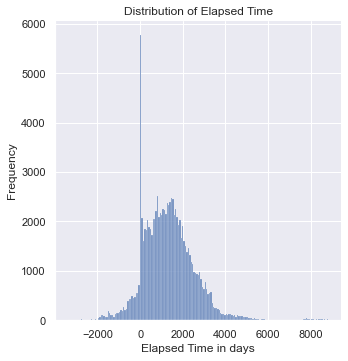

In [59]:
# Plotting the distribution of elapsed_time
sns.displot(analysis_df['elapsed_time'])

plt.title('Distribution of Elapsed Time')
plt.xlabel('Elapsed Time in days')
plt.ylabel('Frequency')

plt.show()

In [58]:
# Display games with negative elapsed_time
negative_elapsed_time_rows = analysis_df[analysis_df["elapsed_time"] < 0]
display(negative_elapsed_time_rows)

,y,date,app_id,title,date_release,rating,positive_ratio,user_reviews,win,mac,...,achievements,average_playtime,median_playtime,owners,steam_deck,user_id,reviews,hours,tendency_to_review,elapsed_time
4345435,False,2017-01-27,305620,The Long Dark,2017-08-01,Very Positive,91,83883,True,True,...,40,760,227,1000-2000,True,848585,3,124.699997,0.040541,-186
5484968,True,2018-10-25,646570,Slay the Spire,2019-01-23,Overwhelmingly Positive,97,108391,True,True,...,43,3034,1857,1000-2000,True,4674587,3,373.500000,0.008929,-90
1237873,True,2017-06-28,431960,Wallpaper Engine,2018-11-01,Overwhelmingly Positive,98,572319,True,False,...,17,1731,542,5000-10000,True,4669421,4,4.300000,0.011628,-491
3266365,False,2016-09-04,346110,ARK: Survival Evolved,2017-08-27,Very Positive,83,465818,True,True,...,32,14154,1470,5000-10000,True,5042927,7,0.200000,0.004909,-357
1979623,True,2016-09-18,435150,Divinity: Original Sin 2 - Definitive Edition,2017-09-14,Overwhelmingly Positive,95,137279,True,True,...,97,2938,1953,2000-5000,True,5530028,3,11.500000,0.011364,-361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4949707,False,2020-01-02,794260,Outward Definitive Edition,2022-05-17,Mostly Positive,73,17234,True,False,...,44,1373,2315,100-200,True,2099539,2,30.200001,0.009434,-866
5074235,False,2018-07-28,313120,Stranded Deep,2022-08-10,Mostly Positive,75,36171,True,True,...,8,272,246,500-1000,True,5620014,13,0.600000,0.232143,-1474
5136551,True,2015-12-15,313120,Stranded Deep,2022-08-10,Mostly Positive,75,36171,True,True,...,8,272,246,500-1000,True,1380457,1,15.000000,0.032258,-2430
1132440,True,2015-06-25,252490,Rust,2018-02-08,Very Positive,87,722973,True,True,...,48,9352,2234,5000-10000,True,1105053,2,201.300003,0.037736,-959


The distribution of elapsed time looks pretty much like a normal distribution, with some peculiar aspects: 
- An high number of records have an elapsed time equal to 0. This means that the users reviewed the games on the same release date, which shows an high engagement with the community;
- Upper outliers reach values up to 8000 days, showing that some users review - and probably also buy - games way after their release; 
- A small number of games with a negative elapsed time of nearly -2000 days. This indicates that some users submitted reviews for games prior to their official release date. It's important to consider that Steam offers early access or beta versions of certain games, allowing users to play and provide feedback ahead of the game's full launch. In such cases, reviews can be submitted even though the final release date has yet to arrive. This phenomenon might explain the presence of negative elapsed times in our dataset, reflecting the unique nature of game distribution and player engagement on the Steam platform. 

### Exploration of review tendency

In [51]:
# Describe the variable
analysis_df["tendency_to_review"].describe()

count    100000.000000
mean          0.070451
std           0.186838
min           0.000106
25%           0.012346
50%           0.028571
75%           0.066667
max           3.200000
Name: tendency_to_review, dtype: float64

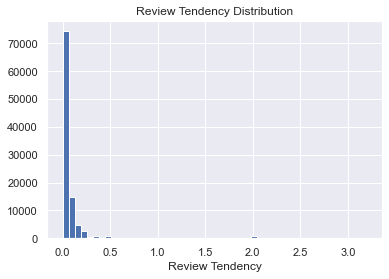

In [52]:
# Create a histogram of review_tendency variable in the first subplot
plt.hist(analysis_df["tendency_to_review"], bins=50)
plt.title("Review Tendency Distribution")
plt.xlabel("Review Tendency")
plt.show()

The distribution of the variable review_tendency suggests that users tend to review a relatively small number of games. The mean value of 0.054 and the median value of 0.027 indicate that on average, users leave a review for only a small fraction of the games they own. Moreover, we need to take into account that every user recorded in the dataset has left at least one review. This suggests that the value of tendency to review calculated on the whole population would be considerely lower.

We can assume, as a consequence, that users only review games when they have a strong opinion about it.

## Model Construction

In the following part, a Logistic Regression model is being used to predict whether a user would like a game or not, which is represented by the binary target variable 'y'. The dataset is first split into features (X) and target (y) and then further split into training and validation sets.

Two versions of the logistic model are created and compared:

The first logistic model uses a limited set of features: 'price_final', 'positive_ratio', 'hours', 'median_playtime'. A preprocessor is created using ColumnTransformer and StandardScaler to standardize these numerical features. A pipeline is created with the preprocessor and a LogisticRegression model with L2 regularization. GridSearchCV is used to optimize the penalty hyperparameter ('C') and regularization type ('penalty') over a range of values, using 10-fold cross-validation and F1 score as the evaluation metric.
The second logistic model adds more features to the first model: 'reviews', 'products', 'discount', 'funny', 'helpful', 'user_reviews', 'price_original', 'required_age', 'achievements'. A new preprocessor is created to standardize these additional numerical features. The same pipeline, grid search, and cross-validation process from the first model is used to optimize the hyperparameters and evaluate the model.
The performance of the second model is compared to the first model to see if adding more features improved the F1 score.

In the third part, Synthetic Minority Over-sampling Technique (SMOTE) is added to the pipeline to address potential class imbalance in the target variable 'y'. A new parameter grid is created to optimize SMOTE's sampling strategy, the number of nearest neighbors, and the logistic regression penalty hyperparameter. Grid search and cross-validation are performed on this pipeline, and the model's performance is compared to the second logistic model to see if adding SMOTE improved the F1 score.
In summary, a logistic regression model is used in this code to predict whether a user would like a game or not based on various features. The model is optimized and compared across different sets of features and with the addition of SMOTE to address class imbalance.

**Train-Test Split** AAAAAAAA

### Model 1: Content Similarity Score

While this is model...

In [54]:
textual_df.head()

,title,description,tags,genres,steamspy_tags,categories,full_text
app_id,,,,,,,
304390,FOR HONOR™,"carve path destruction intense, believable bat...",medieval swordplay action multiplayer pvp figh...,action,medieval action swordplay,single-player online multiplayer online coop s...,single-player online multiplayer online coop s...
306130,The Elder Scrolls® Online,join 20 players award-winning online multiplay...,rpg mmorpg open world adventure fantasy explor...,massive-multiplayer rpg,rpg open world mmorpg,mmo steam trading cards partial controller sup...,mmo steam trading cards partial controller sup...
238960,Path of Exile,"exile, struggling survive dark continent wraec...",free-to-play action rpg hack and slash rpg mul...,action adventure free-to-play indie massive-mu...,free-to-play action rpg hack and slash,single-player multiplayer online multiplayer m...,single-player multiplayer online multiplayer m...
730,Counter-Strike: Global Offensive,counter-strike: global offensive (cs: go) expa...,fps shooter multiplayer competitive action tea...,action free-to-play,fps multiplayer shooter,multiplayer steam achievements full controller...,multiplayer steam achievements full controller...
255710,Cities: Skylines,cities: skylines modern classic city simulatio...,city builder simulation building management st...,simulation strategy,city builder simulation building,single-player steam achievements steam trading...,single-player steam achievements steam trading...


In [55]:
# Define the custom class
class SimilarityGenerator:
    
    def __init__(self, similarity):
        self.similarity = similarity
        
        # Define multi_review dataframe within the class
        duplicated_user_ids = user_df[user_df.duplicated(subset=["user_id"], keep=False)]["user_id"].unique()
        self.multi_review = user_df[user_df["user_id"].isin(duplicated_user_ids)].reset_index(drop=True)
        
    def transform(self, X):
        similarities = []
        for i in range(len(X)):
            user = X[i][0]
            game = X[i][1]
            sim = self.AverageSimilarityCalculator(user, game)
            similarities.append(sim)
        return np.array(similarities).reshape(-1, 1)
    
    def AverageSimilarityCalculator(self, user, game):
        user_ratings = self.multi_review[self.multi_review["user_id"] == user]
        other_games = user_ratings[user_ratings['app_id'] != game]
        other_games_titles = other_games['app_id']
        filtered_game_similarity_df = self.similarity.loc[game, other_games_titles] * other_games.set_index('app_id')["y"]
        return filtered_game_similarity_df.mean()


In [56]:
# Create the pipeline
SVD_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', strip_accents='ascii', use_idf=False)),
    ('svd', TruncatedSVD(n_components=160, random_state=70))
])

# Fit the pipeline on the full text data
SVD_pipeline.fit(textual_df['full_text'])

# Compute the similarity matrix on the full text data
reduced_features = SVD_pipeline.transform(textual_df['full_text'])
similarity_matrix = 1 - pairwise_distances(reduced_features, metric='cosine')

### Model 2: Logistic Regression

### Model 3: Decision Tree

## Model Evaluation

## Rule-based discount choice

After defining the best performing model, a rule-based discount choice function has been developed to aid Steam in making decisions regarding personalized discount offers for games. This function receives several arguments including user_id, app_id, and various threshold values for different discount levels (namely, eighty_treshold, sixty_threshold, forty_threshold, twenty_threshold, and no_discount_threshold). The function uses a rule-based approach to determine the discount level based on the probability of the individual user liking the game, as predicted by the _final_model_.

The thresholds have a pre-defined value, selected based on our perception of what could be a good business decision. However, Steam can decide to set its own threshold values, in case the company's business needs and goals differ from our point of view.

The primary goal of the discount predictor is to understand and meet users' preferences, not only to suggest games they may enjoy but also to encourage them to try new games that differ from their usual preferences, thanks to the discounts offered. The discounts not only boost game sales but also enhance users' perception of the games, adding value both for Steam and its users. 

In [2]:
def discount_predictor(user_id, app_id, no_discount_threshold=0.8, twenty_threshold=0.7, forty_threshold=0.5, sixty_threshold=0.4, eighty_threshold=0.3):
    
    # Find the row in final_df that corresponds to the given user and app IDs
    user_row = final_df.loc[(final_df['user_id'] == user_id) & (final_df['app_id'] == app_id)]
    
    if len(user_row) == 0:
        raise ValueError("User and app ID combination not found in dataframe.")
    
    # Make a prediction with the final model using the features from the user_row
    prediction = final_model.predict_proba(user_row.drop(['user_id', 'app_id', 'y'], axis=1))
    probability_of_liking = prediction[0][1]
    
    # Determine which discount to offer based on the probability of liking the game
    if probability_of_liking >= no_discount_threshold:
        print(f"""Customer has a probability of liking the selected game of {probability_of_liking*100}%. 
        \nOffer no discount""")
        return final_df[final_df['app_id' == app_id]]['price_original']
    
    elif probability_of_liking >= twenty_threshold:
        print(f"""Customer has a probability of liking the selected game of {probability_of_liking*100}%. 
        \nOffer a 20% discount""")
        return final_df[final_df['app_id' == app_id]]['price_original']*0.8
    
    elif probability_of_liking >= forty_threshold:
        print(f"""Customer has a probability of liking the selected game of {probability_of_liking*100}%. 
        \nOffer a 40% discount""")
        return final_df[final_df['app_id' == app_id]]['price_original']*0.6        
    
    elif probability_of_liking >= sixty_threshold:
        print(f"""Customer has a probability of liking the selected game of {probability_of_liking*100}%. 
        \nOffer a 60% discount""")
        return final_df[final_df['app_id' == app_id]]['price_original']*0.4
    
    elif probability_of_liking >= eighty_threshold:
        print(f"""Customer has a probability of liking the selected game of {probability_of_liking*100}%. 
        \nOffer a 80% discount""")
        return final_df[final_df['app_id' == app_id]]['price_original']*0.2
    
    else:
        print(f"""Customer has a probability of liking the selected game of {probability_of_liking*100}%. 
        \nDo not offer the game.""")